# **Naive bayes for spam filter**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /home/idir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Read the File**

In [11]:
df = pd.read_csv("spam_ham_dataset.csv")

In [12]:
df.head(5)

,id,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


/home/idir/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

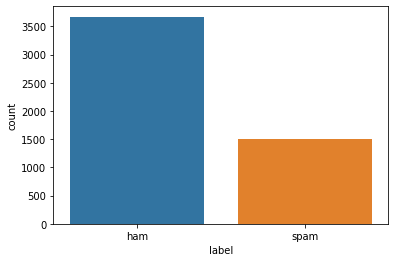

In [5]:
sn.countplot(df["label"])

## **Remove unnecessary columns**

In [6]:
df.drop("id",axis=1,inplace=True)
df.drop("label_num",axis=1,inplace=True)

## **Data Cleaning**
#### 1. *Remove Syntax*
#### 2. *Lowering Case*
#### 3. *Split Into An Array Of Word*
#### 4. *Remove StopWords*

In [7]:
def clean(df): 
    dsc =  df.copy()
    dsc["text"] = dsc["text"].str.translate(str.maketrans('', '', string.punctuation))
    dsc["text"] = dsc["text"].str.lower()
    dsc["text"] = dsc["text"].str.split()
    dsc["text"]=[[word for word in k if word not in stopwords.words('english')]for k in dsc["text"]]
    return dsc

In [8]:

dsc = clean(df)

### *Remove the word 'subject' which is repeated in all emails*

In [9]:
for mail in dsc['text']:
    mail.pop(0)


In [14]:
dsc.head(5)

,label,text
0,ham,"[enron, methanol, meter, 988291, follow, note,..."
1,ham,"[hpl, nom, january, 9, 2001, see, attached, fi..."
2,ham,"[neon, retreat, ho, ho, ho, around, wonderful,..."
3,spam,"[photoshop, windows, office, cheap, main, tren..."
4,ham,"[indian, springs, deal, book, teco, pvr, reven..."


### *Randomize the data set*

In [15]:
data_randomized = dsc.sample(frac=1, random_state=42)

### *Split into  training  and test set*

In [16]:
training_test_index = round(len(data_randomized) * 0.8)
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

In [17]:
X_train = training_set['text']
X_test  = test_set['text']

Y_train = training_set['label']
Y_test  = test_set['label']

## **Build a bag of words**

In [18]:
vocabulary = list(set(X_train.sum()))
len_voc = len(vocabulary)

## **Calculate the probabilities**

In [19]:


spam_messages = X_train[Y_train == 'spam'] 
ham_messages = X_train[Y_train == 'ham'] 

N_spam = len(spam_messages)
N_ham = len(ham_messages)
P_spam = len(spam_messages) / len(X_train)
P_ham = len(ham_messages) / len(X_train)

Nb_words_in_spam = spam_messages.apply(len).sum()
Nb_words_in_ham = ham_messages.apply(len).sum()



In [20]:
words_spam_frequency = {vocabulary[i]: 0 for i in range(len_voc)}
words_ham_frequency ={vocabulary[i]: 0 for i in range(len_voc)}

for mail in spam_messages:
 for mot in mail: 
     words_spam_frequency [mot] += 1
for mail in ham_messages:
 for mot in mail: 
     words_ham_frequency [mot] += 1



## **Classify**

In [21]:
def p_w_spam(word , alpha):
    if word in words_spam_frequency:
        return (words_spam_frequency[word] + alpha)/(Nb_words_in_spam + alpha * len_voc)
    else:
        return 1  

def p_w_ham(word,alpha):
    if word in words_ham_frequency:
        return (words_ham_frequency[word] + alpha)/(Nb_words_in_ham + alpha * len_voc)
    else:
        return 1  

In [22]:
def predict(mail,alpha):
    PS = P_spam
    PH = P_ham
    for word in mail:
        PS *=p_w_spam(word,alpha)
        PH *=p_w_ham(word,alpha)
    if PS > PH:
        return 'spam'
    else:
        return 'ham'

## **Optimize alpha hyperparameter**

In [26]:
alpha_test = [accuracy_score(Y_test.values,[predict(mot,i) for mot in X_test.values]) for i in range (30)]

Text(0.5, 1.0, 'Accuracy en fonction de alpha')

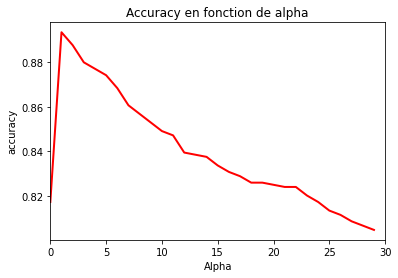

In [27]:
X = [i for i in range(30)]

plt.plot(X,alpha_test, color = 'red', linestyle = 'solid', linewidth = 2,
 markerfacecolor = 'blue', markersize = 5)
plt.xlim(0,30)
plt.xlabel('Alpha')
plt.ylabel('accuracy')

plt.title('Accuracy en fonction de alpha')

**The best value of alpha is 1**

In [28]:
Alpha = 1

In [29]:
y_pred = [predict(mot,Alpha) for mot in X_test.values]

In [31]:
accuracy_score(Y_test.values,y_pred)

0.8936170212765957

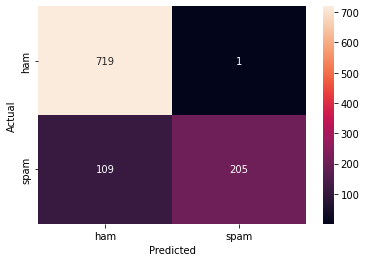

In [32]:

data = {'y_Actual':    Y_test.values,
        'y_Predicted': y_pred
        }
d = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(d['y_Actual'], d['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.show()

In [33]:
sorted_word_ham = {k: v for k, v in sorted(words_spam_frequency.items(),reverse = True, key=lambda item: item[1] )}

## *Optimize the hyperparameter: the size of the training set*

In [34]:
def model_accuracy(df,trainig_size):
    data_randomized = dsc.sample(frac=1, random_state=42)
    training_test_index = round(len(data_randomized) * trainig_size)
    test_index = len(data_randomized) -round(len(data_randomized) * 0.3)
    training_set = data_randomized[:training_test_index].reset_index(drop=True)
    test_set = data_randomized[test_index:].reset_index(drop=True)
    print(len(training_set))
   
   
    X_train = training_set['text']
    X_test  = test_set['text']
    Y_train = training_set['label']
    Y_test  = test_set['label']

    vocabulary = list(set(X_train.sum()))
    len_voc = len(vocabulary)

    spam_messages = X_train[Y_train == 'spam'] 
    ham_messages = X_train[Y_train == 'ham'] 

    N_spam = len(spam_messages)
    N_ham = len(ham_messages)
    P_spam = len(spam_messages) / len(X_train)
    P_ham = len(ham_messages) / len(X_train)

    Nb_words_in_spam = spam_messages.apply(len).sum()
    Nb_words_in_ham = ham_messages.apply(len).sum()

    words_spam_frequency = {vocabulary[i]: 0 for i in range(len_voc)}
    words_ham_frequency ={vocabulary[i]: 0 for i in range(len_voc)}

    for sms in spam_messages:
        for mot in sms: 
            words_spam_frequency [mot] += 1
    for sms in ham_messages:
        for mot in sms: 
            words_ham_frequency [mot] += 1

    def p_w_spam(word , alpha):
        if word in words_spam_frequency:
            return (words_spam_frequency[word] + alpha)/(Nb_words_in_spam + alpha * len_voc)
        else:
            return 1  

    def p_w_ham(word,alpha):
        if word in words_ham_frequency:
            return (words_ham_frequency[word] + alpha)/(Nb_words_in_ham + alpha * len_voc)
        else:
            return 1 
    def predict(mail,alpha):
        PS = P_spam
        PH = P_ham
        for word in mail:
            PS *=p_w_spam(word,alpha)
            PH *=p_w_ham(word,alpha)
        if PS > PH:
            return 'spam'
        else:
            return 'ham'
    y_pred = [predict(mot,Alpha) for mot in X_test.values]
    return [Y_test.values,y_pred]
    
    
     

In [35]:

X = [i/10.0 for i in range(1,11)]
res = [model_accuracy(dsc,k) for k in X]

517
1034
1551
2068
2586
3103
3620
4137
4654
5171


In [36]:
Y = [accuracy_score(x[0],x[1]) for x in res]

In [37]:
from sklearn.metrics import classification_report
print(classification_report(res[0][1],res[0][0]))

              precision    recall  f1-score   support

         ham       1.00      0.88      0.93      1232
        spam       0.67      0.99      0.80       319

    accuracy                           0.90      1551
   macro avg       0.84      0.93      0.87      1551
weighted avg       0.93      0.90      0.91      1551



In [38]:
spam_score = [float(classification_report(x[1], x[0]).split()[10]) for x in res]
ham_score = [float(classification_report(x[1], x[0]).split()[5]) for x in res]

Text(0.5, 1.0, 'Accuracy en fonction de la taille du training set')

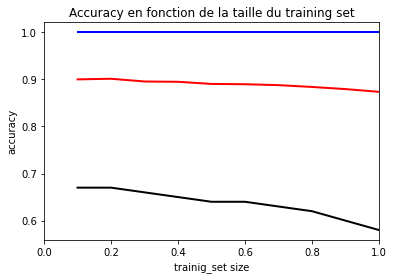

In [39]:
plt.plot(X,Y , color = 'red', linestyle = 'solid', linewidth = 2,
 markerfacecolor = 'red', markersize = 5)
plt.xlabel('trainig_set size')
plt.ylabel('accuracy')
plt.title('Accuracy en fonction de la taille du training set')

## **Leger overfiting**
####  **  *On pas besoin de beaceaup de mail pour arriver à une precision correcte avec ce model* 
####  ** *On remarque aussi que aucun mail n'est classifier comme un spam*

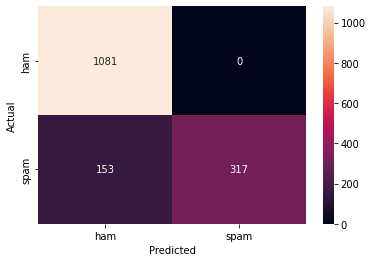

In [40]:
data = {'y_Actual':    res[1][0],
        'y_Predicted': res[1][1]
        }
d = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(d['y_Actual'], d['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.show()